In [1]:
import pandas as pd

In [2]:
tb = pd.read_csv('ocular-disease-recognition-odir5k/full_df.csv')
tb.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
import tensorflow as tf
import numpy as np
import os




def _parse_function(filename, label):
    # Read and decode the image
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, [224, 224])
    image_normalized = image_resized / 255.0  # Normalize to [0, 1]

    return image_normalized, label

def make_dataset(path):
  filenames = os.listdir(path)
  files = []
  labels = []
  for file in filenames:
    if file.split('.')[0][-4:] == 'left':
      label = tb.loc[tb.loc[:, 'Left-Fundus'] == file, :]
    else:
      label = tb.loc[tb.loc[:, 'Right-Fundus'] == file, :]

    if len(label) > 0:
      files.append(path + file)
      labels.append(label.iloc[0, -12:-4].to_numpy('int64'))

  dataset = tf.data.Dataset.from_tensor_slices((files, labels))
  dataset = dataset.map(_parse_function)
  return dataset, len(files)


dataset, dataset_size = make_dataset('ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/')
dataset = dataset.shuffle(buffer_size=1000)

##
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

##
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

##
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

for images, labels in train_dataset:
  print(images.shape)
  print(labels.shape)
  break

(32, 224, 224, 3)
(32, 8)


In [4]:
tf.__version__

'2.17.0'

In [5]:
import os
from matplotlib import pyplot as plt
import cv2

(2000, 2584, 3)


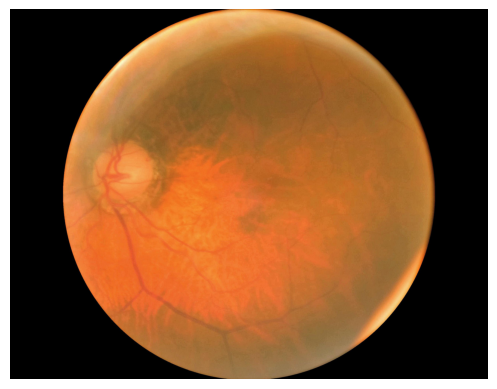

In [6]:
img = os.listdir('./ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/')[0]
img = cv2.imread(f'./ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/{img}')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')
print(img.shape)

#ViT

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, num_patches, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection = layers.Dense(embedding_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # print(self.num_patches)
        patches = tf.reshape(patches, [batch_size, self.num_patches, tf.shape(images)[-1] * self.patch_size ** 2])
        # print(patches.shape)
        return self.projection(patches)

In [9]:
def create_vit_model(input_shape, num_classes, patch_size, embedding_dim, num_heads, num_transformer_blocks):
    # Calculate number of patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    inputs = keras.Input(shape=input_shape)

    # Patch Embedding
    patches = PatchEmbedding(patch_size, num_patches, embedding_dim)(inputs)

    # Positional Encoding
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embedding_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + position_embedding(positions)

    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        # Layer Normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-Head Self Attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # Feed Forward Network
        x3 = layers.Dense(embedding_dim, activation='relu')(x3)
        x3 = layers.Dense(embedding_dim)(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Classification Head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    outputs = layers.Dense(num_classes, activation='sigmoid')(representation)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [10]:
# Parameters
input_shape = (224, 224, 3)
num_classes = 8
patch_size = 16
embedding_dim = 64
num_heads = 4
num_transformer_blocks = 8

# Create the Vision Transformer model
vit_model = create_vit_model(
    input_shape=input_shape,
    num_classes=num_classes,
    patch_size=patch_size,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_transformer_blocks=num_transformer_blocks
)

# Compile the model
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Use binary cross-entropy for multi-label classification
    metrics=['accuracy']
)


In [14]:
vit_model.summary()
saveweight_callback = keras.callbacks.ModelCheckpoint('mnist_bestweights.keras', save_best_only=True, monitor='val_loss', mode='min')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 196, 64)   │     49,216 │ input_layer[0][0] │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 64)   │      4,160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ dense_2[0][0],    │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 64)   │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 196, 64)   │          0 │ dense_4[0][0],    │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,948,250 (7.43 MB)

 Trainable params: 649,416 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,298,834 (4.95 MB)

In [12]:
history = vit_model.fit(train_dataset, validation_data = val_dataset, batch_size=32, epochs=100, verbose = 1, callbacks = saveweight_callback)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.2878 - loss: 0.3770 - val_accuracy: 0.3398 - val_loss: 0.3538
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3353 - loss: 0.3547 - val_accuracy: 0.3994 - val_loss: 0.3389
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.3592 - loss: 0.3528 - val_accuracy: 0.3979 - val_loss: 0.3355
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.3527 - loss: 0.3499 - val_accuracy: 0.3934 - val_loss: 0.3405
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 168s 968ms/step - accuracy: 0.3789 - loss: 0.3482 - val_accuracy: 0.3115 - val_loss: 0.3508
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 166s 957ms/step - accuracy: 0.3801 - loss: 0.3470 - val_accuracy: 0.4218 - val_loss: 0.3377
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 167s 966ms/step - accuracy: 0.3939 - loss: 0.3408 - val_accuracy: 0.4039 - val_loss: 0.3389
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 168s 971ms/step - accuracy: 0.3938 - los

In [15]:
history2 = vit_model.fit(train_dataset, validation_data = val_dataset, batch_size=32, epochs=100, verbose = 1, callbacks = saveweight_callback)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 157s 910ms/step - accuracy: 0.7818 - loss: 0.1246 - val_accuracy: 0.5529 - val_loss: 0.3146
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 160s 926ms/step - accuracy: 0.7711 - loss: 0.1348 - val_accuracy: 0.5961 - val_loss: 0.2936
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 161s 931ms/step - accuracy: 0.7781 - loss: 0.1283 - val_accuracy: 0.6080 - val_loss: 0.2990
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 163s 943ms/step - accuracy: 0.7890 - loss: 0.1182 - val_accuracy: 0.6066 - val_loss: 0.2910
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 164s 950ms/step - accuracy: 0.7954 - loss: 0.1165 - val_accuracy: 0.5976 - val_loss: 0.3085
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 164s 949ms/step - accuracy: 0.7703 - loss: 0.1334 - val_accuracy: 0.5976 - val_loss: 0.3006
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 165s 953ms/step - accuracy: 0.8006 - loss: 0.1105 - val_accuracy: 0.6349 - val_loss: 0.2785
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 165s 954ms/step - accuracy: 

In [17]:
vit_model.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.6850 - loss: 0.3817


[0.4147067368030548, 0.6716195940971375]

In [19]:
vit_model.save_weights('ViT64_4_8_243epoch.weights.h5')

In [54]:
vit_model.load_weights('ViT64_4_8_bestweights.keras')

In [56]:
result = vit_model.evaluate(test_dataset)
print(f'loss = {result[0]}, accuracy = {result[1]}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - accuracy: 0.6861 - loss: 0.3357
loss = 0.32426148653030396, accuracy = 0.7057949304580688


In [ ]:
predict = vit_model.predict(test_dataset)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


2024-08-08 13:14:52.660589: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


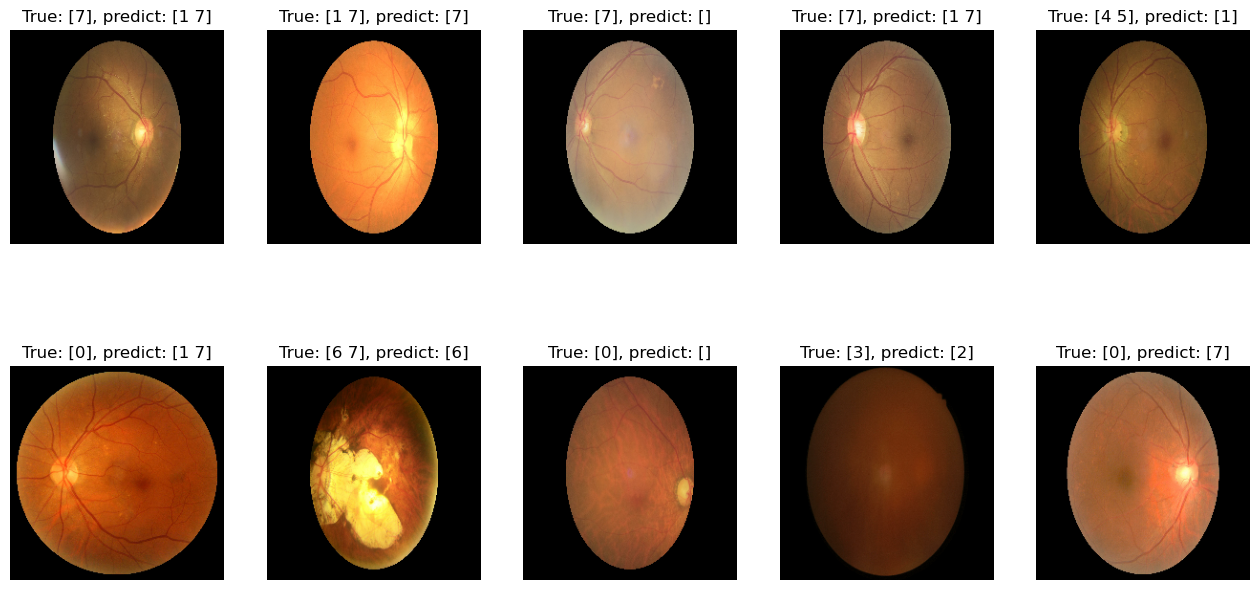

In [47]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16, 8))
j = 1
for batch in test_dataset:
    imgs, lbls = batch
    lbls = np.round(lbls)
    lbls_id = np.where(lbls == 1)
    predicts = vit_model.predict(imgs, verbose = 0)
    predicts = np.round(predicts)
    predicts_id = np.where(predicts == 1)
    for i in range(batch_size):
        if len(predicts_id[1][predicts_id[0] == i]) == len(lbls_id[1][lbls_id[0] == i]):
            if not (lbls_id[1][lbls_id[0] == i] == predicts_id[1][predicts_id[0] == i]).all():
                # print(lbls[0], predicts[0].round())
                if j > 10:
                    break
                plt.subplot(2, 5, j)
                plt.imshow(imgs[i].numpy())
                plt.axis('off')
                plt.title(f'True: {lbls_id[1][lbls_id[0] == i]}, predict: {predicts_id[1][predicts_id[0] == i]}')
                j += 1
        else:
            if j > 10:
                    break
            plt.subplot(2, 5, j)
            plt.imshow(imgs[i].numpy())
            plt.axis('off')
            plt.title(f'True: {lbls_id[1][lbls_id[0] == i]}, predict: {predicts_id[1][predicts_id[0] == i]}')
            j += 1

In [50]:
# Assuming history1, history2, and history3 are the histories you want to combine
histories = [history.history, history2.history]

# Initialize a new dictionary to hold the combined history
combined_history = {}

# Iterate over all keys in the history (e.g., 'loss', 'accuracy')
for key in histories[0].keys():
    # Concatenate the lists from each history for each key
    combined_history[key] = []
    for history in histories:
        combined_history[key].extend(history[key])


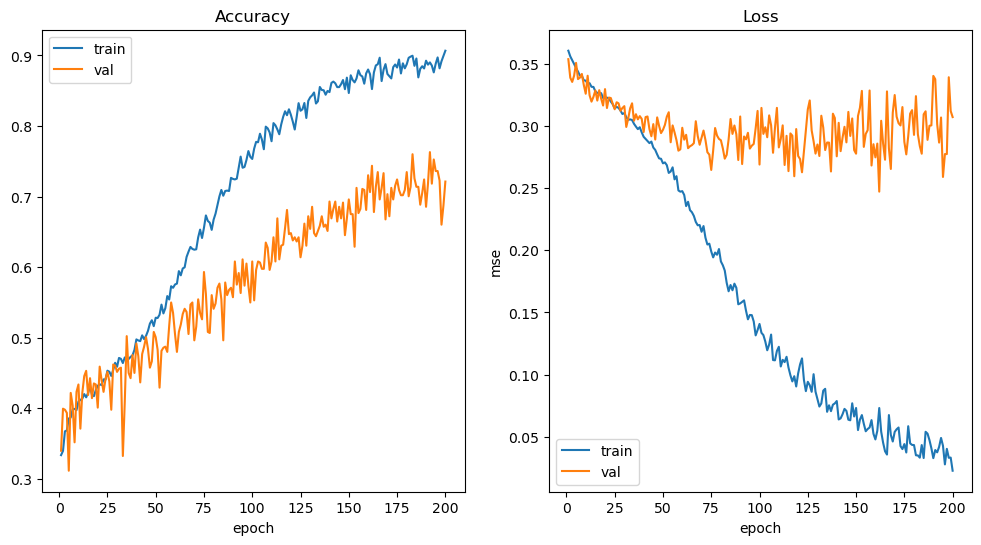

In [53]:
hist = combined_history
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(range(1,201), hist['accuracy'], label = 'train')
plt.plot(range(1,201), hist['val_accuracy'], label = 'val')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(range(1,201), hist['loss'], label = 'train')
plt.plot(range(1,201), hist['val_loss'], label = 'val')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend();